In [1]:
import os
import requests
import asyncio

import math
import rasterio as rs
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio import plot

import folium
from folium import plugins

import geopandas as gpd
import pandas as pd
import numpy as np
import shapefile

import matplotlib.pyplot as plt
from osgeo import gdal
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep


### DATA

In [10]:
main_path = '/Users/aida/Documents/Modules/Thesis/lake-victoria/data/planet/lake-area/TOL-8Bands/'
img_name = 'composite.tif'
udm_name = 'composite_udm2.tif'
aoi = 'tol-explorer-aoi.shp'
cage_labels = 'train-data/tol-cage-labels.shp'
water_labels = 'train-data/tol-water-labels.shp'

In [9]:
# Open our image
satdat = rs.open(main_path + img_name)
# satdat is our open dataset object
print(satdat)

udm = rs.open(main_path + udm_name)
aoi = gpd.read_file(main_path + aoi)

<open DatasetReader name='/Users/aida/Documents/Modules/Thesis/lake-victoria/data/planet/lake-area/TOL-8Bands/composite.tif' mode='r'>


DriverError: /Users/aida/Documents/Modules/Thesis/lake-victoria/data/planet/lake-area/TOL-8Bands/tol-explorer-aoi.shp: No such file or directory

In [11]:
img = rs.open(main_path + img_name)
xres = (img.bounds.right - img.bounds.left) / img.width
yres = (img.bounds.top - img.bounds.bottom) / img.height

print(xres, yres)
print("Are the pixels square: {}".format(xres == yres))

3.0 3.0
Are the pixels square: True


In [4]:
# Get the image's coordinate reference system
print(satdat.crs)
# Minimum bounding box in projected units (meters), in our zone
print(satdat.bounds)

EPSG:32736
BoundingBox(left=602567.9999999998, bottom=9983029.0, right=628886.9999999998, top=10025557.0)


### EDA

In [5]:
## And provides a sequence of band indexes.  These are one indexing, not zero indexing like Numpy arrays.
print(satdat.indexes)
print(satdat.crs)
# Get dimensions, in projected units (using the example GeoTIFF, that's meters)
width_in_projected_units = satdat.bounds.right - satdat.bounds.left
height_in_projected_units = satdat.bounds.top - satdat.bounds.bottom
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))
# Number of rows and columns (pixels)
print("Rows: {}, Columns: {}".format(satdat.height, satdat.width))

# This dataset's projection uses meters as projected units.  
# What are the dimensions of a single pixel in meters?

xres = width_in_projected_units / satdat.width
yres = height_in_projected_units / satdat.height

print(xres, yres)
print("Are the pixels square: {}".format(xres == yres)) #sanity check

(1, 2, 3, 4)
EPSG:32736
Width: 26319.0, Height: 42528.0
Rows: 14176, Columns: 8773
3.0 3.0
Are the pixels square: True


In [6]:
# PlanetScope 4-band band order: BGRNIR
b = satdat.read(1)
g = satdat.read(2)
r = satdat.read(3)
n = satdat.read(4)


def normalize(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def scale(band):
    return (band * (0.000001))


In [7]:
# # Normalize the bands
rn = normalize(r)
gn = normalize(g)
bn = normalize(b)
nn = normalize(n)
bands_nor = np.array([bn,gn,rn,nn])

In [8]:
#scale the bands
rsc = scale(r)
gsc = scale(g)
bsc = scale(b)
nsc = scale(n)
bands_sc = np.array([rsc,gsc,gsc,nsc])

In [11]:
img = satdat
img.shape

image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 14176, 8773)

In [10]:
import numpy as np
from skimage import exposure
# # Transpose and rescale the image 
img = satdat
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000
image = image.transpose(2,0,1)
# Plot the resulting image
#fig = plt.figure(figsize=(20,12))
#show(image, transform=img.transform)

print(img.crs)

EPSG:32736


### WATER INDICIS

In [12]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

ndwi_ep = es.normalized_diff(gsc, nsc)

# check range NDWI values, excluding NaN
np.min(ndwi_ep), np.nanmax(ndwi_ep)

(-0.9712230215827339, 0.9937304075235108)

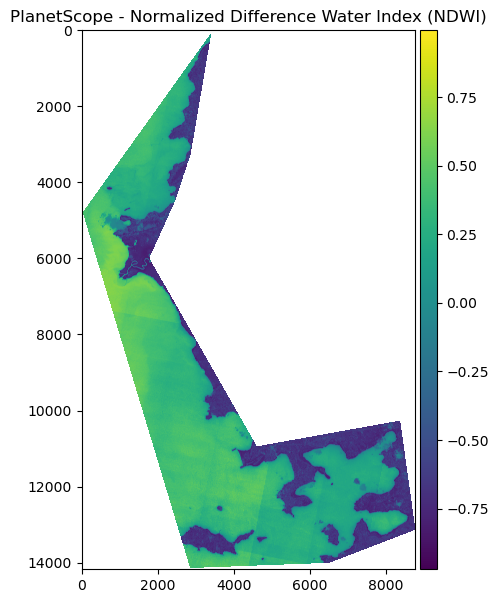

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
titles = "PlanetScope - Normalized Difference Water Index (NDWI)"
# Plot your data
fig, ax = plt.subplots(figsize=(7, 7))

p = plt.imshow(ndwi_ep, cmap="viridis")
# # Add title and colorbar to show the index
plt.title(titles)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(p, cax=cax)
#save the image
#plt.imsave(main_path + "composit-ndwi.png", ndwi_ep)

In [14]:
# Generate the water and land masks
water_mask = np.zeros_like(ndwi_ep)
land_mask = np.zeros_like(ndwi_ep)

water_mask[ndwi_ep >= -0.25] = 1
#water_mask[ndwi_ep < -0.25] = 255

land_mask[ndwi_ep < -0.25] = 1

In [ ]:
# In the image below, colored areas are those identified as water
# plt.imshow(water_mask)
# plt.title("top of the lake water mask")
# plt.show()

In [ ]:
i, j = np.where(water_mask > 0)

In [ ]:
rgb = np.dstack((rn, gn, bn))

ind = np.random.randint(0, len(i))
window = 20
patch = rgb[i[ind] - window:i[ind] + window, j[ind] - window: j[ind] + window]

plt.imshow(10 * patch)

In [ ]:
import numpy as np
from skimage import exposure
img = np.dstack((r, g, b, n))
img_masked= img * np.repeat(water_mask[:, :, np.newaxis], 4, axis=2)
img_masked_t = img_masked.transpose(1,2,0)
p2, p98 = np.percentile(img_masked_t, (2,98))
img_msked_scaled = exposure.rescale_intensity(img_masked_t, in_range=(p2, p98))
img_msked_scaled_t = img_msked_scaled.transpose(2,0,1)

fig = plt.figure(figsize=(8,8))
plt.imshow(img_msked_scaled_t)
plt.imsave(main_path + 'tol_img_masked.tif', img_masked)

In [ ]:
### Training Data
cages = gpd.read_file(main_path + cage_labels)
cages['class_name'] = 'cage'
cages['id'] = 1
cages.head()
water = gpd.read_file(main_path + water_labels)
water['class_name'] = 'water'
water['id'] = 2
water.head()
# Bring the shapefiles into common cordinate system
cages_prj = cages.to_crs('EPSG:32736')
water_prj = water.to_crs('EPSG:32736')
 
# # Merge/Combine multiple shapefiles into one
training_data = gpd.pd.concat([cages_prj, water_prj])
training_data.head()
training_data.to_crs('EPSG:32736')
#Export merged geodataframe into shapefile
training_data.to_file(main_path + "train-data/tol_training_data.shp")

In [ ]:
training_data.plot(figsize=(8,8))

In [ ]:
img = gdal.Open(main_path + img_name)
nrows = img.RasterXSize
ncols = img.RasterYSize
print(nrows, ncols)

In [ ]:
gdf = gpd.read_file(main_path + "train-data/tol_training_data.shp")
gdf.head()

class_ids = training_data['id'].unique()
class_names = training_data['class_name'].unique()
(class_ids, class_names)

df = pd.DataFrame({'label': class_names, 'id': class_ids})
df.to_csv(main_path + 'train-data/class_lookup.csv')

# gdf['id'] = gdf['class']
# print('gdf with ids', gdf.head())
# gdf.crs

In [ ]:
# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)
gdf_test = gdf.drop(gdf_train.index)
print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test', gdf_test.shape)
gdf_train.to_file(main_path + 'train-data/train.shp')
gdf_test.to_file(main_path + 'train-data/test.shp')


In [ ]:
shp_fn = 'train-data/tol_training_data.shp'
rst_fn = satdat
out_fn = 'train-data/train_rasterized.tif'

In [ ]:
from osgeo import ogr, osr

In [ ]:
input_shp = ogr.Open(main_path + 'train-data/tol_training_data.shp')
source_layer = input_shp.GetLayer()
source_layer
defn = source_layer.GetLayerDefn()
column_names = []
for n in range(defn.GetFieldCount()):
    fdefn = defn.GetFieldDefn(n)
    column_names.append(fdefn.name)
column_names

In [ ]:
output_raster_location = main_path + 'train-data/train_data_rasterised.tif'
pixel_size = 0.000325872 ### This needs to be changed
xmin, xmax, ymin, ymax = source_layer.GetExtent()
xmin, xmax, ymin, ymax

x_res = int(round(xmax-xmin)/ pixel_size)
y_res = int(round(ymax-ymin)/ pixel_size)

x_res, y_res
# target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1, gdal.GDT_Int16, ['COMPRESS=lzw'])
# target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0, -pixel_size))
# srse = osr.SpatialReference()
# proj = 'EPSG:32736'
# srse.SetWellKnownGeogCS(proj)
# target_ds.SetProjection(srse.ExportToWkt())
# band = target_ds.GetRasterBand(1)
# band.SetNoDataValue(-9999)
# band.Fill(-9999)
# target_ds.GetRasterBand(1).SetNoDataValue(-9999)
# band.Fill(-9999)

# # Set the NoData value for the band
# band.SetNoDataValue(-9999)
# # Flush the changes to the raster dataset
# band.FlushCache()

# # Close the raster dataset
# target_ds = None

# gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [1], options = ['ALL_TOUCHED=TRUE', 'ATTRIBUTE=class'])
# target_ds = None


In [ ]:
gdal.RasterizeLayer(target_ds, [1], source_layer, None, None, [1], options = ['ALL_TOUCHED=TRUE', 'ATTRIBUTE=class'])
target_ds = None


In [ ]:
tr_rst = rs.open(output_raster_location)
tr_rst.min()

In [ ]:
print(tr_rst.indexes)
print(tr_rst.crs)
# # Get dimensions, in projected units (using the example GeoTIFF, that's meters)
width_in_projected_units = tr_rst.bounds.right - tr_rst.bounds.left
height_in_projected_units = tr_rst.bounds.top - tr_rst.bounds.bottom
print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))
# Number of rows and columns (pixels)
print("Rows: {}, Columns: {}".format(tr_rst.height, tr_rst.width))


In [ ]:
satDat = gdal.Open(main_path + img_name)
satDat

In [ ]:
satDat.GetGeoTransform()

In [ ]:
gdf = gpd.read_file(main_path + "train-data/tol_training_data.shp")
gdf.head()